<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/DualAscent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

time_steps 10 iter 0 primal_solver_gradient_descent .. 
time_steps 20 iter 0 primal_solver_gradient_descent .. 
time_steps 30 iter 0 primal_solver_gradient_descent .. 
time_steps 40 iter 0 primal_solver_gradient_descent .. 
time_steps 50 iter 0 primal_solver_gradient_descent .. 
time_steps 60 iter 0 primal_solver_gradient_descent .. 
time_steps 70 iter 0 primal_solver_gradient_descent .. 
time_steps 80 iter 0 primal_solver_gradient_descent .. 
time_steps 90 iter 0 primal_solver_gradient_descent .. 


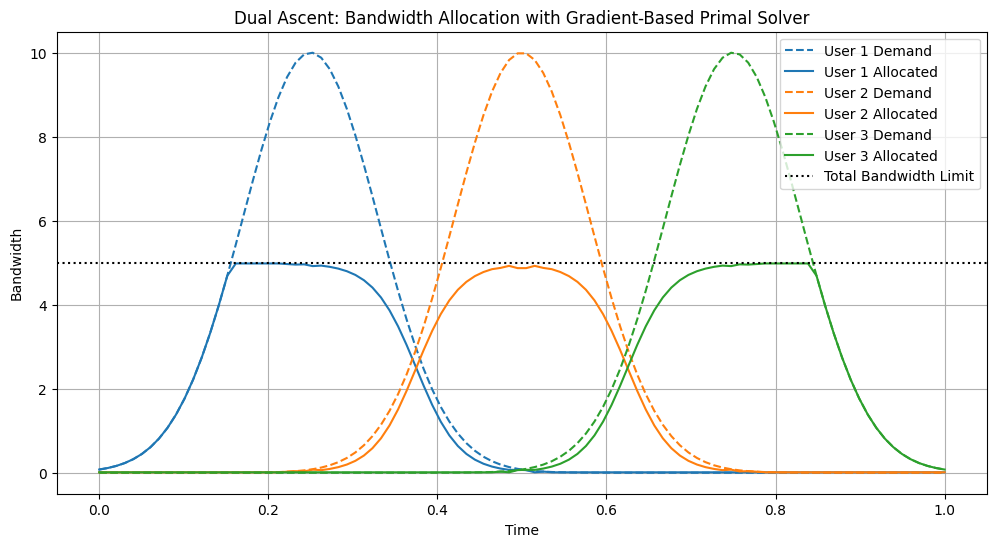

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Problem Parameters
time_steps = 100
b_total = 5.0
alpha = 0.01  # Dual ascent step size
max_iters = 500  # Dual ascent iterations per time step
n_users = 3

# Generate Overlapping Gaussian Demands
t = np.linspace(0, 1, time_steps)
centers = [0.25, 0.5, 0.75]
width = 0.08

demand_profiles = [
    np.exp(-0.5 * ((t - c) / width) ** 2) * b_total*2
    for c in centers
]

# Define f(x) and grad L(x, lambda)
def f_i(x_i, d_i):
    return -d_i * np.log(x_i)

def grad_Lagrangian(x_i, lambda_k, d_i):
    return -d_i / x_i + lambda_k

def primal_solver_gradient_descent(d_i, lambda_k, x_init=1.0, lr=0.05, max_primal_iters=500, tol=1e-5):
    x = x_init
    grad_history = []

    for _ in range(max_primal_iters):
        grad = grad_Lagrangian(x, lambda_k, d_i)
        grad_history.append(grad)

        # Early stopping based on recent gradient std
        if len(grad_history) > 20:
            recent_std = np.std(grad_history[-20:])
            if recent_std < tol:
                break

        x -= lr * grad
        x = max(x, 0.01)  # Ensure positivity

    return x

# Allocate bandwidth over time
allocation_history = np.zeros((n_users, time_steps))

# Dual Ascent Over Time
for time_idx in range(time_steps):
    d_i = np.array([profile[time_idx] for profile in demand_profiles])
    d_i = np.maximum(d_i, 0.01)

    lambda_k = 1.0

    for k in range(max_iters):
        if time_idx and time_idx % 10 == 0 and not k:
          print (f'time_steps {time_idx} iter {k} primal_solver_gradient_descent .. ')
        # Step 1: Primal Update (Using Gradient Descent + Early Stopping)
        x_i = np.array([
            primal_solver_gradient_descent(demand, lambda_k)
            for demand in d_i
        ])

        x_i = np.minimum(x_i, d_i)
        x_i = np.maximum(x_i, 0.01)

        # Step 2: Residual
        residual = np.sum(x_i) - b_total

        # Step 3: Dual Update
        lambda_k += alpha * residual
        lambda_k = max(lambda_k, 0.01)

    allocation_history[:, time_idx] = x_i

# Plotting
plt.figure(figsize=(12, 6))
colors = ['C0', 'C1', 'C2']

for i in range(n_users):
    plt.plot(t, demand_profiles[i], '--', color=colors[i], label=f'User {i+1} Demand')
    plt.plot(t, allocation_history[i], '-', color=colors[i], label=f'User {i+1} Allocated')

plt.axhline(b_total, color='k', linestyle=':', label='Total Bandwidth Limit')
plt.xlabel('Time')
plt.ylabel('Bandwidth')
plt.title('Dual Ascent: Bandwidth Allocation with Gradient-Based Primal Solver')
plt.legend()
plt.grid()
plt.show()


In [441]:
%%writefile bandwidth_allocation.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define B_TOTAL 100.0f
#define alpha 0.01f

float f_x(float x_i, float d_i) {
    return -d_i * log(x_i);
}

float grad_fx(float x_i, float d_i, float lambda_k) {
    float gamma = 2.0f;
    float beta = 1.5f;

    float exp_term = expf(beta * x_i);
    float lse_grad = gamma * beta * exp_term / (1.0f + exp_term);

    float demand_grad = -d_i / fmaxf(x_i, 0.01f);

    // Cap demand_grad to prevent it from exploding
    if (demand_grad > 1000.0f)
        demand_grad = 1000.0f;
    if (demand_grad < -1000.0f)
        demand_grad = -1000.0f;

    return demand_grad + lse_grad + lambda_k;
}


// primal_solver_gradient_descent
float primal_solver_gradient_descent(float* demands, int user, int time_step, int total_time_steps, float lambda_k) {
    float x_init = 1.0f;
    int max_iters = 1000;
    float tol = 1e-5f;

    float x = x_init;
    float grad_history[20] = {0};
    int grad_history_idx = 0;
    int iter = 0;

    float demand = demands[user * total_time_steps + time_step];
    if (demand < 0.01f) {
        return 0.01f;  // Directly allocate minimal bandwidth if demand is negligible
    }

    while (iter < max_iters) {
        float grad = grad_fx(x, demands[user * total_time_steps + time_step], lambda_k);
        grad_history[grad_history_idx] = grad;
        grad_history_idx = (grad_history_idx + 1) % 20;

        x -= alpha * grad;
        x = fmaxf(x, 0.01f);
        iter++;
    }

    x = fmaxf(x, 0.01f);
    x = fminf(x, B_TOTAL);

    return x;
}

// Gaussian demand generator - centers overlap by 20% either side of each other
void generate_gaussian_demands(float* demands, int n_users, int time_steps) {
    float width = 6.0f;
    for (int i = 0; i < n_users; i++) {
        float center = (i+1)*(time_steps/n_users);
        for (int t = 0.01*time_steps; t < 0.9*time_steps; t++) {
            float x = (t - center)/width;
            float demand = B_TOTAL * 2.0f * expf(-0.5f * x*x);
            demands[i * time_steps + t] = demand;
        }
    }
}

// Save to CSV
void save_csv(const char* filename, float* data, int n_users, int time_steps) {
    FILE* fp = fopen(filename, "w");
    for (int i = 0; i < n_users; i++) {
        for (int t = 0; t < time_steps; t++) {
            fprintf(fp, "%.4f", data[i * time_steps + t]);
            if (t < time_steps - 1)
                fprintf(fp, ",");
        }
        fprintf(fp, "\n");
    }
    fclose(fp);
}

int main(int argc, char**argv) {
    //read no of users from argv
    int N_USERS = atoi(argv[1]);
    int TIME_STEPS = atoi(argv[2]);

    float* demands = (float*)malloc(N_USERS * TIME_STEPS * sizeof(float));
    float* allocations = (float*)malloc(N_USERS * TIME_STEPS * sizeof(float));
    generate_gaussian_demands(demands, N_USERS, TIME_STEPS);

    float lambda_k = 1.0f;  // Persistent dual variable across time

    for (int t = 0; t < TIME_STEPS; t++) {
        float residual = 0.0f;

        for (int u = 0; u < N_USERS; u++) {
            allocations[u * TIME_STEPS + t] =
                primal_solver_gradient_descent(demands, u, t, TIME_STEPS, lambda_k);
            residual += allocations[u * TIME_STEPS + t];
        }

        residual -= B_TOTAL;

        // Update lambda_k (dual variable)
        lambda_k += alpha * residual;
        lambda_k = fmaxf(lambda_k, 0.01f);

        // Optional: enforce strict total bandwidth constraint via post-normalization
        float sum_alloc = 0.0f;
        for (int u = 0; u < N_USERS; u++) {
            sum_alloc += allocations[u * TIME_STEPS + t];
        }
        if (sum_alloc > B_TOTAL) {
            float scale = B_TOTAL / sum_alloc;
            for (int u = 0; u < N_USERS; u++) {
                allocations[u * TIME_STEPS + t] *= scale;
            }
        }

        /* Debug prints (can be commented)
        printf("Timestep %d | Residual: %.4f | Lambda_k: %.4f\n", t, residual, lambda_k);
        for (int u = 0; u < N_USERS; u++) {
            printf("  User %d allocation: %.4f\n", u, allocations[u * TIME_STEPS + t]);
        } */
    }

    save_csv("allocations_cpu.csv", allocations, N_USERS, TIME_STEPS);
    save_csv("demands_cpu.csv", demands, N_USERS, TIME_STEPS);

    free(demands);
    free(allocations);
}


Overwriting bandwidth_allocation.cu


In [442]:
!nvcc -gencode arch=compute_75,code=sm_75 bandwidth_allocation.cu -o bandwidth_allocation_cpu
!time ./bandwidth_allocation_cpu 3 100

bandwidth_allocation.cu(35): warning #177-D: variable "tol" was declared but never referenced
      float tol = 1e-5f;
            ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

bandwidth_allocation.cu(38): warning #550-D: variable "grad_history" was set but never used
      float grad_history[20] = {0};
            ^


real	0m0.006s
user	0m0.006s
sys	0m0.000s


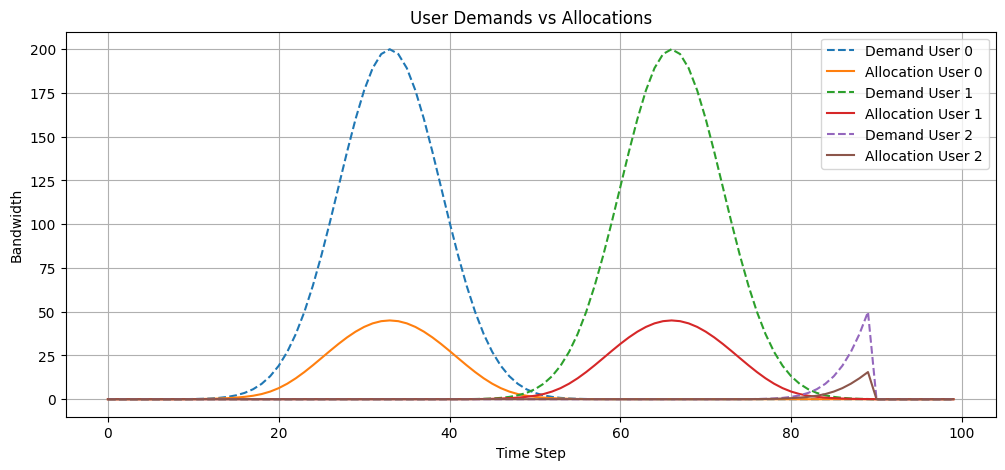

In [443]:
import numpy as np
import matplotlib.pyplot as plt

demands = np.loadtxt('demands_cpu.csv', delimiter=',')
allocations = np.loadtxt('allocations_cpu.csv', delimiter=',')

plt.figure(figsize=(12, 5))

# Example: plot 5 users' demand vs. allocation
for i in range(3):
    plt.plot(demands[i], label=f'Demand User {i}', linestyle='--')
    plt.plot(allocations[i], label=f'Allocation User {i}')

plt.xlabel("Time Step")
plt.ylabel("Bandwidth")
plt.title("User Demands vs Allocations")
plt.legend()
plt.grid(True)
plt.show()


In [444]:
%%writefile bandwidth_allocation.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define B_TOTAL 100.0f
#define ALPHA 0.001f

__device__ float grad_fx(float x_i, float d_i, float lambda_k) {
    float gamma = 2.0f;
    float beta = 1.5f;

    float exp_term = expf(beta * x_i);
    float lse_grad = gamma * beta * exp_term / (1.0f + exp_term);

    float demand_grad = -d_i / fmaxf(x_i, 0.01f);

    // Cap demand_grad to prevent it from exploding
    if (demand_grad > 1000.0f)
        demand_grad = 1000.0f;
    if (demand_grad < -1000.0f)
        demand_grad = -1000.0f;

    return demand_grad + lse_grad + lambda_k;
}


__global__ void primal_solver_kernel(float* demands, float* allocations, float lambda_k, int time_step, int total_time_steps, int n_users) {
    int user = blockIdx.x * blockDim.x + threadIdx.x;
    if (user >= n_users)
        return;

    int idx = user * total_time_steps + time_step;
    float demand = demands[idx];
    float x = 1.0f;
    float alpha = 0.01f;

    if (demand < 0.01f) {
        allocations[idx] = 0.01f;
        return;
    }

    int max_iters = 1000;
    for (int iter = 0; iter < max_iters; iter++) {
        float grad = grad_fx(x, demand, lambda_k);
        x -= alpha * grad;
        if (x < 0.01f)
            x = 0.01f;
        if (x > B_TOTAL)
            x = B_TOTAL;
    }

    allocations[idx] = x;
}

void generate_gaussian_demands(float* demands, int n_users, int time_steps) {
    float width = 6.0f;
    for (int i = 0; i < n_users; i++) {
        float center = (i+1) * (time_steps / n_users);
        for (int t = 0.01 * time_steps; t < 0.9 * time_steps; t++) {
            float x = (t - center) / width;
            float demand = B_TOTAL * 2.0f * expf(-0.5f * x * x);
            demands[i * time_steps + t] = demand;
        }
    }
}

void save_csv(const char* filename, float* data, int n_users, int time_steps) {
    FILE* fp = fopen(filename, "w");
    for (int u = 0; u < n_users; u++) {
        for (int t = 0; t < time_steps; t++) {
            fprintf(fp, "%.4f", data[u * time_steps + t]);
            if (t < time_steps - 1)
                fprintf(fp, ",");
        }
        fprintf(fp, "\n");
    }
    fclose(fp);
}

int main(int argc, char* argv[]) {
    int n_users = atoi(argv[1]);
    int time_steps = atoi(argv[2]);

    printf("Running with %d users and %d time steps.\n", n_users, time_steps);

    float* h_demands = (float*)malloc(n_users * time_steps * sizeof(float));
    float* h_allocations = (float*)malloc(n_users * time_steps * sizeof(float));

    generate_gaussian_demands(h_demands, n_users, time_steps);

    float* d_demands;
    float* d_allocations;
    cudaMalloc(&d_demands, n_users * time_steps * sizeof(float));
    cudaMalloc(&d_allocations, n_users * time_steps * sizeof(float));

    cudaMemcpy(d_demands, h_demands, n_users * time_steps * sizeof(float), cudaMemcpyHostToDevice);

    float lambda_k = 1.0f;
    int threads_per_block = 256;
    int num_blocks = (n_users + threads_per_block - 1) / threads_per_block;

    for (int t = 0; t < time_steps; t++) {
        primal_solver_kernel<<<num_blocks, threads_per_block>>>(d_demands, d_allocations, lambda_k, t, time_steps, n_users);
        cudaDeviceSynchronize();

        cudaMemcpy(h_allocations, d_allocations, n_users * time_steps * sizeof(float), cudaMemcpyDeviceToHost);

        // --- Enforce strict total bandwidth constraint via post-normalization (on host) ---
        float sum_alloc = 0.0f;
        for (int u = 0; u < n_users; u++) {
            sum_alloc += h_allocations[u * time_steps + t];
        }

        if (sum_alloc > B_TOTAL) {
            float scale = B_TOTAL / sum_alloc;
            for (int u = 0; u < n_users; u++) {
                h_allocations[u * time_steps + t] *= scale;
            }
            // Optional: Update device with scaled allocations
            cudaMemcpy(d_allocations, h_allocations, n_users * time_steps * sizeof(float), cudaMemcpyHostToDevice);
        }

        // --- Lambda update ---
        float residual = sum_alloc - B_TOTAL;
        lambda_k += ALPHA * residual;
        if (lambda_k < 0.01f)
            lambda_k = 0.01f;

        if (t % 10 == 0 || t == time_steps - 1)
            printf("Timestep %d: Lambda_k = %.4f | Residual = %.4f\n", t, lambda_k, residual);
    }

    save_csv("allocations_gpu.csv", h_allocations, n_users, time_steps);
    save_csv("demands_gpu.csv", h_demands, n_users, time_steps);

    printf("Saved allocations_gpu.csv and demands_gpu.csv\n");

    free(h_demands);
    free(h_allocations);
    cudaFree(d_demands);
    cudaFree(d_allocations);

    return 0;
}




Overwriting bandwidth_allocation.cu


In [445]:
!nvcc -gencode arch=compute_75,code=sm_75 bandwidth_allocation.cu -o bandwidth_allocation_gpu
!time ./bandwidth_allocation_gpu 5000 100

Running with 5000 users and 100 time steps.
Timestep 0: Lambda_k = 0.9500 | Residual = -50.0024
Timestep 10: Lambda_k = 244.6649 | Residual = 2727.0391
Timestep 20: Lambda_k = 259.8620 | Residual = -50.0024
Timestep 30: Lambda_k = 259.3621 | Residual = -50.0024
Timestep 40: Lambda_k = 258.8622 | Residual = -50.0024
Timestep 50: Lambda_k = 258.3623 | Residual = -50.0024
Timestep 60: Lambda_k = 257.8625 | Residual = -50.0024
Timestep 70: Lambda_k = 257.3626 | Residual = -50.0024
Timestep 80: Lambda_k = 256.8627 | Residual = -50.0024
Timestep 90: Lambda_k = 256.3628 | Residual = -50.0024
Timestep 99: Lambda_k = 255.9129 | Residual = -50.0024
Saved allocations_gpu.csv and demands_gpu.csv

real	0m0.586s
user	0m0.358s
sys	0m0.220s


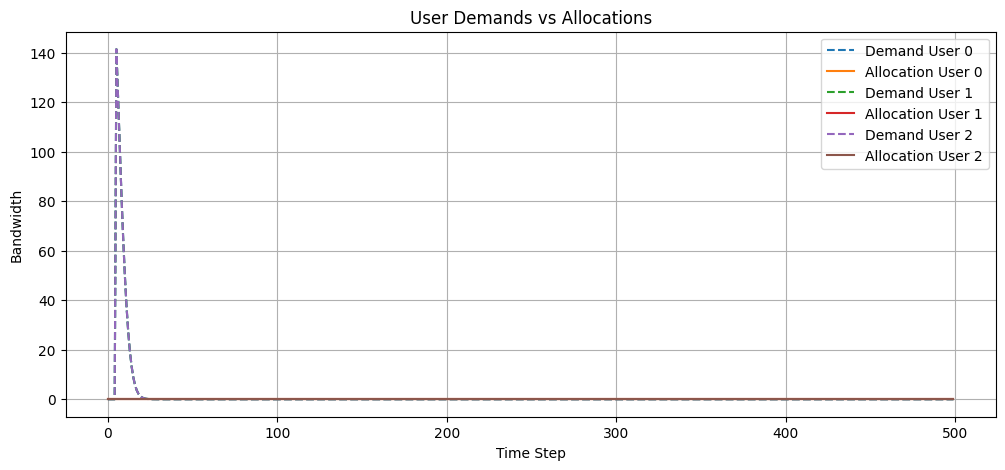

In [451]:
import numpy as np
import matplotlib.pyplot as plt

demands = np.loadtxt('demands_gpu.csv', delimiter=',')
allocations = np.loadtxt('allocations_gpu.csv', delimiter=',')

plt.figure(figsize=(12, 5))

# Example: plot 5 users' demand vs. allocation
for i in range(3):
    plt.plot(demands[i], label=f'Demand User {i}', linestyle='--')
    plt.plot(allocations[i], label=f'Allocation User {i}')

plt.xlabel("Time Step")
plt.ylabel("Bandwidth")
plt.title("User Demands vs Allocations")
plt.legend()
plt.grid(True)
plt.show()



--- 5 users | 100 time steps ---
Running CPU version...

real	0m0.018s
user	0m0.008s
sys	0m0.004s
CPU time: 0.0180 seconds
Running CUDA version...
Running with 5 users and 100 time steps.
Timestep 0: Lambda_k = 0.9000 | Residual = -99.9500
Timestep 10: Lambda_k = 0.0100 | Residual = -84.5402
Timestep 20: Lambda_k = 0.0100 | Residual = -54.5460
Timestep 30: Lambda_k = 0.0100 | Residual = -68.9295
Timestep 40: Lambda_k = 0.0100 | Residual = -54.1583
Timestep 50: Lambda_k = 0.0100 | Residual = -68.9295
Timestep 60: Lambda_k = 0.0100 | Residual = -54.1583
Timestep 70: Lambda_k = 0.0100 | Residual = -68.9295
Timestep 80: Lambda_k = 0.0100 | Residual = -54.1583
Timestep 90: Lambda_k = 0.0100 | Residual = -99.9500
Timestep 99: Lambda_k = 0.0100 | Residual = -99.9500
Saved allocations_gpu.csv and demands_gpu.csv

real	0m0.248s
user	0m0.045s
sys	0m0.198s
CUDA time: 0.2480 seconds

--- 50 users | 100 time steps ---
Running CPU version...

real	0m0.084s
user	0m0.083s
sys	0m0.001s
CPU time: 0.084

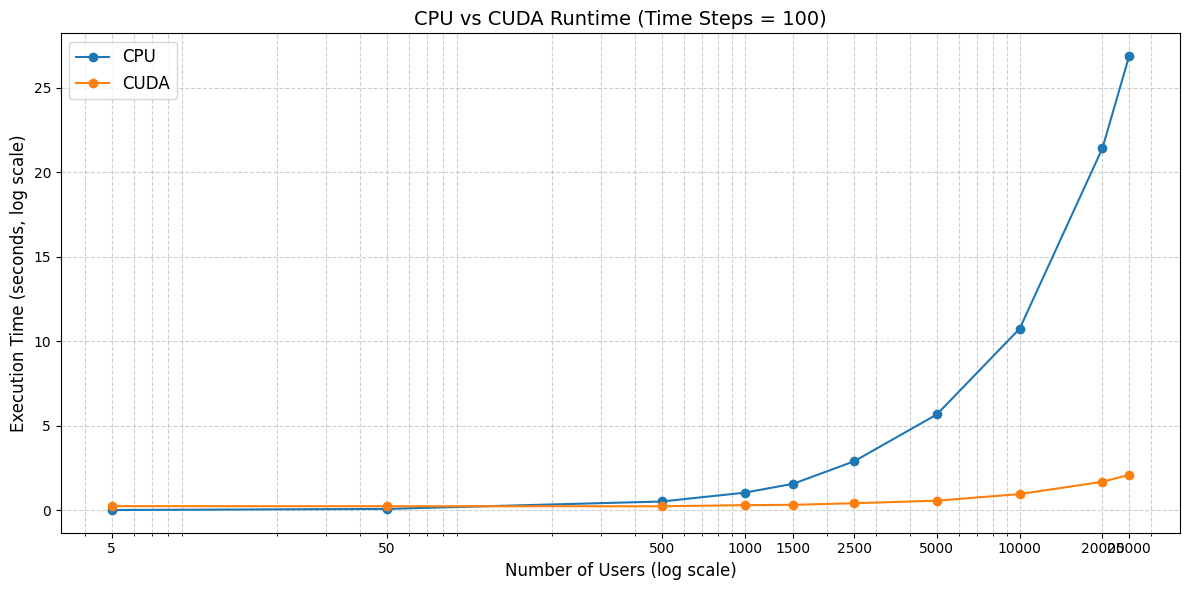

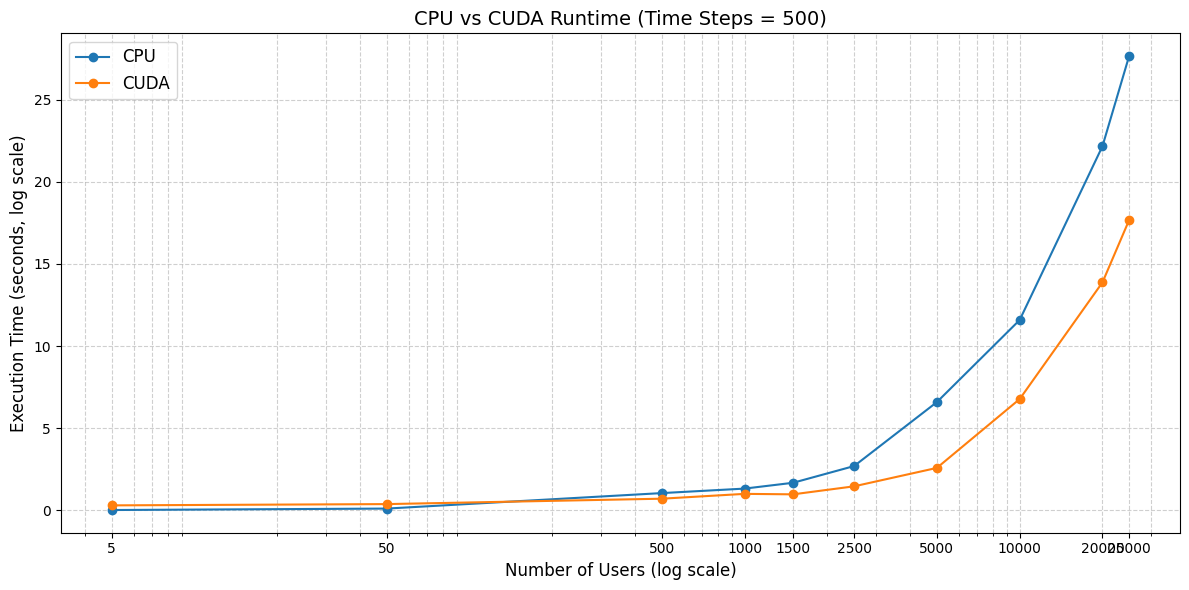

In [450]:
import numpy as np
import matplotlib.pyplot as plt

user_counts = [5, 50, 500, 1000, 1500, 2500, 5000, 10000, 20000, 25000]
time_steps_list = [100, 500]

results = {}

cpu_binary = "./bandwidth_allocation_cpu"
cuda_binary = "./bandwidth_allocation_gpu"

def extract_real_time(time_output):
    """Extracts 'real' time from shell time output."""
    for line in time_output:
        if 'real' in line:
            parts = line.strip().split()
            try:
                time_str = parts[1]  # e.g. 0m0.015s
                minutes = float(time_str.split('m')[0])
                seconds = float(time_str.split('m')[1].replace('s', ''))
                return minutes * 60 + seconds
            except:
                return float('nan')
    return float('nan')

def has_valid_data(times):
    return np.any([np.isfinite(t) and t > 0 for t in times])

for time_steps in time_steps_list:
    results[time_steps] = {}
    for users in user_counts:
        results[time_steps][users] = {}

        print(f"\n--- {users} users | {time_steps} time steps ---")

        # CPU Run
        print("Running CPU version...")
        cpu_output = !/bin/bash -c "time $cpu_binary {users} {time_steps}" 2>&1
        print('\n'.join(cpu_output))  # Optional: Debug
        cpu_time = extract_real_time(cpu_output)
        print(f"CPU time: {cpu_time:.4f} seconds")
        results[time_steps][users]['cpu'] = cpu_time

        # CUDA Run
        cuda_exists = !test -f $cuda_binary && echo 1 || echo 0
        if cuda_exists[0] == '0':
            print("CUDA binary not found. Skipping CUDA test.")
            results[time_steps][users]['cuda'] = float('nan')
            continue

        print("Running CUDA version...")
        cuda_output = !/bin/bash -c "time $cuda_binary {users} {time_steps}" 2>&1
        print('\n'.join(cuda_output))  # Optional: Debug
        cuda_time = extract_real_time(cuda_output)
        print(f"CUDA time: {cuda_time:.4f} seconds")
        results[time_steps][users]['cuda'] = cuda_time


# Plotting CPU vs CUDA times
for time_steps in time_steps_list:
    cpu_times = [results[time_steps][users]['cpu'] for users in user_counts]
    cuda_times = [results[time_steps][users]['cuda'] for users in user_counts]

    if not (has_valid_data(cpu_times) or has_valid_data(cuda_times)):
        print(f"Skipping plot for time_steps={time_steps} (no valid data).")
        continue

    plt.figure(figsize=(12, 6))
    plt.plot(user_counts, cpu_times, marker='o', label='CPU')
    plt.plot(user_counts, cuda_times, marker='o', label='CUDA')

    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Number of Users (log scale)', fontsize=12)
    plt.ylabel('Execution Time (seconds, log scale)', fontsize=12)
    plt.title(f'CPU vs CUDA Runtime (Time Steps = {time_steps})', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.xticks(user_counts, labels=[str(u) for u in user_counts])
    plt.tight_layout()
    plt.show()


In [448]:
import pandas as pd

df1 = pd.read_csv('allocations_cpu.csv')
df2 = pd.read_csv('allocations_gpu.csv')

df1.equals(df2)

True